In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer, load_digits, load_iris
from sklearn.metrics import mean_squared_error

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder

from category_encoders import OneHotEncoder

from sklearn.pipeline import make_pipeline
import sklearn
sklearn.set_config(display = 'diagram')
from sklearn.feature_selection import RFE

### Read in the data set:

In [2]:
df = pd.read_csv('./datasets/train.csv')

### Inspect Data:

In [3]:
pd.options.display.max_rows = None

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [4]:
df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


### Data Cleaning:

In [5]:
# data description of 'MS SubClass' --> (Nominal): Identifies the type of dwelling involved in the sale.
# Showing in data set as an int, converting to object to use as classes

df_clean = df
df_clean['MS SubClass'] = df_clean['MS SubClass'].astype('object')

In [6]:
# 'Total Bsmt SF' and 'Garage Area' both have 1 NaN value each.
# Deleting both rows --> data set from 2051 to 2049

df_clean = df_clean[df_clean['Total Bsmt SF'].notna()]
df_clean = df_clean[df_clean['Garage Area'].notna()]
df_clean.shape

(2049, 81)

''

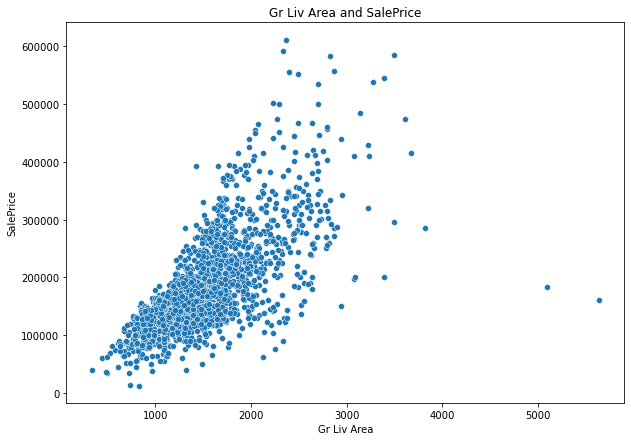

In [7]:
# from data dictionary:
# SPECIAL NOTES: There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). 
# Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). 
# I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

plt.figure(figsize = (10, 7))
sns.scatterplot(data = df_clean, x = 'Gr Liv Area', y ='SalePrice')
plt.title('Gr Liv Area and SalePrice')
;

In [8]:
# Two outliers remain in the test data, remvoing to improve model as these will skew my results.

df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]
df_clean.shape

(2047, 81)

### Create X and y:

In [9]:
X = df_clean[['Gr Liv Area', 'Overall Qual', 'Total Bsmt SF', 'Garage Area', 'Neighborhood', 'MS SubClass']]
y = df_clean['SalePrice']

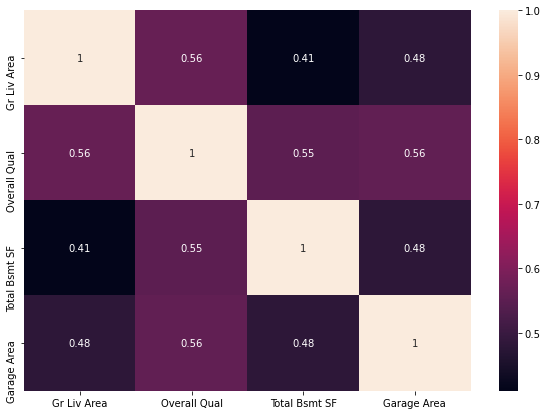

In [10]:
# Checking to see if any columns are highly correlated to each other.
# Overall Qual has some overlap, but believe it's an important feature.

plt.figure(figsize = (10, 7))
sns.heatmap(X.corr(), annot = True);

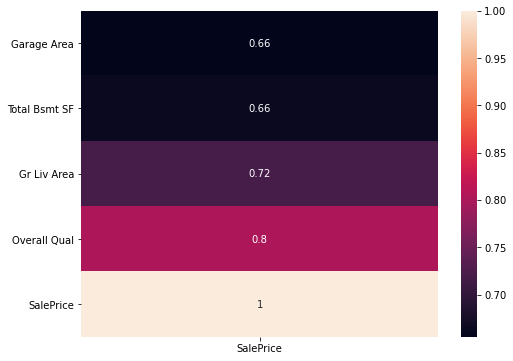

In [11]:
# Heatmap of correlation between selected columns and Sale Price (numerical columns only)

numerical_df = df_clean[['Gr Liv Area', 'Overall Qual', 'Total Bsmt SF', 'Garage Area', 'SalePrice']]


plt.figure(figsize=(8,6))
sns.heatmap(numerical_df.corr()[['SalePrice']].sort_values(by='SalePrice'), annot=True);

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 45)

### Check to see if p values are low (all columns are significant):

In [13]:
# Must OHE before running ols summary and removing one column as the reference column.

ohe = OneHotEncoder(use_cat_names = True)

In [14]:
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
X_train_encoded.columns

Index(['Gr Liv Area', 'Overall Qual', 'Total Bsmt SF', 'Garage Area',
       'Neighborhood_OldTown', 'Neighborhood_Edwards', 'Neighborhood_NAmes',
       'Neighborhood_NWAmes', 'Neighborhood_StoneBr', 'Neighborhood_CollgCr',
       'Neighborhood_Timber', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt',
       'Neighborhood_IDOTRR', 'Neighborhood_Sawyer', 'Neighborhood_MeadowV',
       'Neighborhood_Veenker', 'Neighborhood_NPkVill', 'Neighborhood_Gilbert',
       'Neighborhood_Mitchel', 'Neighborhood_BrkSide', 'Neighborhood_SawyerW',
       'Neighborhood_NoRidge', 'Neighborhood_Somerst', 'Neighborhood_BrDale',
       'Neighborhood_Blueste', 'Neighborhood_SWISU', 'Neighborhood_Landmrk',
       'Neighborhood_Blmngtn', 'Neighborhood_ClearCr', 'Neighborhood_GrnHill',
       'Neighborhood_Greens', 'MS SubClass_50.0', 'MS SubClass_20.0',
       'MS SubClass_120.0', 'MS SubClass_60.0', 'MS SubClass_30.0',
       'MS SubClass_70.0', 'MS SubClass_180.0', 'MS SubClass_90.0',
       'MS SubClass_16

In [16]:
X_train_encoded.drop(['Neighborhood_Sawyer', 'MS SubClass_60.0'], axis = 1, inplace = True)
X_test_encoded.drop(['Neighborhood_Sawyer', 'MS SubClass_60.0'], axis = 1, inplace = True)

In [17]:
X_train_encoded_const = sm.add_constant(X_train_encoded)

In [18]:
model = sm.OLS(y_train, X_train_encoded_const).fit()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     207.7
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:58:36   Log-Likelihood:                -17915.
No. Observations:                1535   AIC:                         3.592e+04
Df Residuals:                    1489   BIC:                         3.617e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.913e+04   6363.735     -7.720      0.000   -6.16e+04   -3.66e+04
Gr Liv Area             52.9466      2.787     18.999      0.000      47.480      58.413
Overall Qual          1.689e+04    931.080     18.138      0.000    1.51e+04    1.87e+04
Total Bsmt SF           29.5361      2.837     10.410      0.000      23.971      35.101
Garage Area             35.4486      4.772      7.428      0.000      26.087      44.810
Neighborhood_OldTown  -1.49e+04   4631.329     -3.217      0.001    -2.4e+04   -5815.067
Neighborhood_Edwards -1244.4689   4304.475     -0.289      0.773   -9687.948    7199.010
Neighborhood_NAmes   -4570.5255   3621.478     -1.262      0.207   -1.17e+04    2533.216
Neighborhood_NWAmes  -9827.0322   5047.876     -1.947      0.052   -1.97e+04      74.672
Neighborhood_StoneBr  7.451e+04   7015.114     10.621      0.000    6.07e+04    8.83e+04
Neighborhood_CollgCr  4712.0513   4290.497      1.098      0.272   -3704.010    1.31e+04
Neighborhood_Timber   1.828e+04   6254.910      2.922      0.004    6009.458    3.05e+04
Neighborhood_Crawfor  2.415e+04   5575.692      4.332      0.000    1.32e+04    3.51e+04
Neighborhood_NridgHt  5.779e+04   5387.454     10.726      0.000    4.72e+04    6.84e+04
Neighborhood_IDOTRR  -1.302e+04   5698.130     -2.286      0.022   -2.42e+04   -1846.264
Neighborhood_MeadowV  1.582e+04   8867.846      1.784      0.075   -1575.091    3.32e+04
Neighborhood_Veenker  1.948e+04   8611.465      2.262      0.024    2585.049    3.64e+04
Neighborhood_NPkVill  1.344e+04   1.02e+04      1.323      0.186   -6485.286    3.34e+04
Neighborhood_Gilbert  1928.4832   4735.094      0.407      0.684   -7359.680    1.12e+04
Neighborhood_Mitchel  3286.0215   4820.904      0.682      0.496   -6170.464    1.27e+04
Neighborhood_BrkSide -1438.1111   5439.550     -0.264      0.792   -1.21e+04    9231.884
Neighborhood_SawyerW  -888.3955   5004.472     -0.178      0.859   -1.07e+04    8928.169
Neighborhood_NoRidge  3.475e+04   6346.236      5.476      0.000    2.23e+04    4.72e+04
Neighborhood_Somerst  1.912e+04   4980.237      3.840      0.000    9355.267    2.89e+04
Neighborhood_BrDale   1.153e+04   1.02e+04      1.127      0.260   -8539.659    3.16e+04
Neighborhood_Blueste   1.47e+04    1.3e+04      1.134      0.257   -1.07e+04    4.01e+04
Neighborhood_SWISU   -1.569e+04   7081.783     -2.216      0.027   -2.96e+04   -1802.001
Neighborhood_Landmrk  2.029e+04   2.95e+04      0.688      0.492   -3.76e+04    7.81e+04
Neighborhood_Blmngtn  1.844e+04   8648.863      2.132      0.033    1478.377    3.54e+04
Neighborhood_ClearCr  3.051e+04   7782.692      3.920      0.000    1.52e+04    4.58e+04
Neighborhood_GrnHill   1.12e+05   2.94e+04      3.805      0.000    5.43e+04     1.7e+05
Neighborhood_Greens   1.516e+04   1.75e+04      0.866    

##### Conclusion:

The four numerical columns all have a p-value of 0, suggesting the coefficients are significant.<br>

1) Gr Liv Area (Continuous): Above grade (ground) living area square feet<br>
2) Overall Qual (Ordinal): Rates the overall material and finish of the house<br>
3) Total Bsmt SF (Continuous): Total square feet of basement area<br>
4) Garage Area (Continuous): Size of garage in square feet<br>

The two object columns vary on significance. <br>

1) Neighborhood (Nominal): Physical locations within Ames city limits (map available)<br>
2) MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.

### Make Pipeline and Inspect with GridSearch

In [20]:
# Pipeline will include polynomial features, standard scaler, and elastic net estimator.

pipe = make_pipeline(OneHotEncoder(use_cat_names = True), PolynomialFeatures(), StandardScaler(), ElasticNet())
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet())])

In [21]:
params = {
    'polynomialfeatures__interaction_only': [True, False],
    'elasticnet__alpha': [.01, .1, 1, 10, 100]
}

In [22]:
gs = GridSearchCV(pipe, params, n_jobs = -1) 
gs.fit(X_train, y_train)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263266802458.63486, tolerance: 897255860.8991612
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': [0.01, 0.1, 1, 10, 100],
                         'polynomialfeatures__interaction_only': [True, False]})

In [23]:
gs.best_params_

{'elasticnet__alpha': 0.1, 'polynomialfeatures__interaction_only': True}

In [24]:
pd.DataFrame(gs.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elasticnet__alpha,param_polynomialfeatures__interaction_only,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,3.788035,0.302842,0.081958,0.012209,0.1,True,"{'elasticnet__alpha': 0.1, 'polynomialfeatures...",0.907149,0.872617,0.858507,0.865540,0.887468,0.878256,0.017339,1
3,3.131014,0.326448,0.062167,0.008514,0.1,False,"{'elasticnet__alpha': 0.1, 'polynomialfeatures...",0.907031,0.873483,0.853697,0.866413,0.887939,0.877713,0.018366,2
5,1.577299,0.125521,0.085754,0.019731,1,False,"{'elasticnet__alpha': 1, 'polynomialfeatures__...",0.901980,0.866586,0.863021,0.864876,0.889165,0.877125,0.015638,3
4,0.935066,0.084054,0.084350,0.027092,1,True,"{'elasticnet__alpha': 1, 'polynomialfeatures__...",0.898191,0.862007,0.866788,0.859041,0.885133,0.874232,0.015023,4
0,2.367052,0.100990,0.073958,0.009688,0.01,True,"{'elasticnet__alpha': 0.01, 'polynomialfeature...",0.899367,0.863890,0.850235,0.864774,0.861700,0.867993,0.016532,5
1,2.420618,0.058233,0.073360,0.014549,0.01,False,"{'elasticnet__alpha': 0.01, 'polynomialfeature...",0.899039,0.862517,0.846946,0.863035,0.860698,0.866447,0.017336,6
7,0.478327,0.032330,0.054770,0.008397,10,False,"{'elasticnet__alpha': 10, 'polynomialfeatures_...",0.818754,0.786401,0.833616,0.811885,0.821419,0.814415,0.015670,7
6,0.505711,0.046465,0.066959,0.015129,10,True,"{'elasticnet__alpha': 10, 'polynomialfeatures_...",0.792369,0.762901,0.816623,0.786286,0.796214,0.790879,0.017305,8
9,0.365987,0.037781,0.040981,0.013331,100,False,"{'elasticnet__alpha': 100, 'polynomialfeatures...",0.363910,0.350930,0.399342,0.382468,0.371818,0.373694,0.016445,9
8,0.391578,0.028618,0.048371,0.006435,100,True,"{'elasticnet__alpha': 100, 'polynomialfeatures...",0.311314,0.300528,0.343589,0.325362,0.318440,0.319846,0.014437,10


The top performer is alpha of 0.1 and interaction only on polynomial features. I am happy with the results because my R-squared mean score is high at 0.88 and it is consistent with a standard deviation of 0.017.

### Finalizing Pipeline and tests

In [25]:
# Make pipeline with results of grid search

pipe = make_pipeline(OneHotEncoder(use_cat_names = True), PolynomialFeatures(interaction_only=True), StandardScaler(), ElasticNet(alpha = 0.1))
pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(alpha=0.1))])

In [26]:
# Fit pipe to training data

pipe.fit(X_train, y_train)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263266802458.63486, tolerance: 897255860.8991612
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Neighborhood', 'MS SubClass'],
                               use_cat_names=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(alpha=0.1))])

In [27]:
# R-squared score on training data

pipe.score(X_train, y_train)

0.9181589395102242

In [28]:
# RMSE score on training data

preds = pipe.predict(X_train)
mean_squared_error(preds, y_train, squared = False)

21872.05484116537

In [29]:
# R-squared score on test data

pipe.score(X_test, y_test)

0.9001242272908516

In [30]:
# RMSE score on test data

preds2 = pipe.predict(X_test)
mean_squared_error(preds2, y_test, squared = False)

27481.05466534694

My train and test R-squared scores are consistent and above 0.9, so I am happy with the final model. Compared to other iterations, the RMSE scores are low and better than the baseline of 83042.

### Fitting pipeline to total data set

In [31]:
# Fit pipeline to total data set in order to create best model using all of the information I have.

pipe.fit(X, y)

C:\Users\Lindsey\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Lindsey\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361817055756.3307, tolerance: 1286605500.408653
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Neighborhood', 'MS SubClass'],
                               use_cat_names=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(alpha=0.1))])

In [32]:
# R-squared score on total data

pipe.score(X, y)

0.9176512607561362

In [33]:
# RMSE score on total data

preds3 = pipe.predict(X)
mean_squared_error(preds3, y, squared = False)

22750.568727933405

The R-squared score is still consistent and the RMSE is in line with the train and test data.

### Creating submission file

In [34]:
# Read in given test data
df_test = pd.read_csv('./datasets/test.csv')

# Adjust MS SubClass to object
df_test['MS SubClass'] = df_test['MS SubClass'].astype('object')

df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [35]:
# Create dataframe with only necessary columns

X_test = df_test[['Gr Liv Area', 'Overall Qual', 'Total Bsmt SF', 'Garage Area', 'Neighborhood', 'MS SubClass']]
X_test.shape

(878, 6)

In [36]:
# Predict prices based on new data

predictions = pipe.predict(X_test)

In [37]:
# Create dataframe for upload

df_sales = pd.DataFrame(predictions, columns = ['SalePrice'])
df_sales.shape

(878, 1)

In [38]:
# Add 'Id' column to price predictions

df_model_final = pd.concat([df_test['Id'], df_sales], axis = 1)
df_model_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         878 non-null    int64  
 1   SalePrice  878 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.8 KB


In [39]:
# Format 'Id' to be an index

df_model_final.set_index('Id', inplace = True)

In [42]:
# Save CSV file

df_model_final.to_csv('./kaggle_submissions/final_submission.csv')